# Welcome to pyRT - The Python Raytracer 

## https://github.com/martinchristen/pyRT


The goal of pyRT is teaching computer graphics.
One part of pyrt is the virtual framebuffer where you can draw Pixels using standard algorithms such as Bresenham's line drawing algorithm.

From Version 0.5.0 an additional goal is better Jupyter integration, this is now done in RGBImage.

Dependencies:
This notebook requires pyrt, pillow, numpy, and numba


### 1. Virtual Framebuffer for Pixel Operations


In [ ]:
from pyrt.renderer import RGBImage
from pyrt.math import Vec2, Vec3
import random

#### 1.2 Animated Virtual Framebuffer in Jupyter


In [ ]:
w = 320
h = 240
image = RGBImage(w, h)
image.clear(Vec3(0.0,0.0,0.4))

In [ ]:
for i in range(5000):
    position = Vec2(random.randint(0, w - 1), random.randint(0, h - 1))
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
   
    image.drawPoint(position, color, 1)

In [ ]:
image.framebuffer()

In [ ]:
for i in range(100):
    pos1 = Vec2(random.randint(0, w - 1), random.randint(0, h - 1))
    pos2 = Vec2(random.randint(0, w - 1), random.randint(0, h - 1))
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
   
    image.drawLine(pos1, pos2, color, 2)
    image.update(fps=30)

#### 1.3 Loading Images

In [ ]:
from pyrt.renderer import loadimage

image2 = loadimage("data/worldmap/world600.jpg")
image2.framebuffer("world")

In [ ]:
image2.drawCircleFilled(Vec2(300,150), radius=10, color=Vec3(1,0,0), fillcolor=Vec3(1,1,0), size=1)
image2.update("world")

In [ ]:
for i in range(100):
    pos = Vec2(random.randint(0, image2.width - 1), random.randint(0, image2.height - 1))
    radius = random.randint(2,20)
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    fillcolor = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
   
    image2.drawCircleFilled(pos, radius, color, fillcolor, 1)
    image2.update("world", fps=30)

#### 1.4 Example: Display Recent Earthquakes on Map

data from USGS: https://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

In [ ]:
import requests
import json
from pyrt.renderer import RGBImage, loadimage
from pyrt.math import Vec2, Vec3

data = requests.get("https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson")
with open("earthquakes.geojson","wb") as file:
    file.write(data.content)

In [ ]:
with open("earthquakes.geojson") as json_file:
    data = json.load(json_file)

In [ ]:
image3 = loadimage("data/worldmap/world600.jpg")

for element in data["features"]:
    mag = element["properties"]["mag"]
    coord = element["geometry"]["coordinates"]
    x = int(image3.width*((coord[0] + 180) / 360))
    y = int(image3.height*((coord[1] + 90) / 180))
    if mag>4.5:
        image3.drawCircleFilled(Vec2(x,y), int(mag), Vec3(0,0,0), Vec3(1,0,0), 1)
image3

#### 1.5 Procedural Images

In [ ]:
from numba import jit
import numpy as np
import math
from pyrt.renderer import RGBImage, loadimage
from pyrt.math import Vec2, Vec3
from pyrt.math import clamp3, cross3, step
from pyrt.math import SimplexNoise, TileableNoise
from pyrt.math import mod

In [ ]:
w = 256
h = 256
image = RGBImage(w, h)
rgb = Vec3()
noise = SimplexNoise()

##### 1.5.1 Stripes and Checkerboard

In [ ]:
for x in range(w):
    for y in range(h):
        xx = x/w # range [0,1[
        yy = y/h # range [0,1[
         
        if mod(6.0*xx, 1.0) < 0.5:                # if 6.0*xx % 1.0 < 0.5:  
            rgb[0] = rgb[1] = rgb[2] = 0
        else:
            rgb[0] = rgb[1] = rgb[2] = 255
        
        image.data[y][x][0] = rgb[0]
        image.data[y][x][1] = rgb[1]
        image.data[y][x][2] = rgb[2]
image

In [ ]:
for x in range(w):
    for y in range(h):
        xx = x/w # range [0,1[
        yy = y/h # range [0,1[
         
        if mod(8.0*yy, 1.0) < 0.5:                # if 8.0*yy % 1.0 < 0.5:  
            rgb[0] = rgb[1] = rgb[2] = 0
        else:
            rgb[0] = rgb[1] = rgb[2] = 255
        
        image.data[y][x][0] = rgb[0]
        image.data[y][x][1] = rgb[1]
        image.data[y][x][2] = rgb[2]
image

In [ ]:
for x in range(w):
    for y in range(h):
        xx = x/w # range [0,1[
        yy = y/h # range [0,1[
         
        if (mod(4.0*xx, 1.0) < 0.5) ^ (mod(4.0*yy, 1.0) < 0.5):
            rgb[0] = rgb[1] = rgb[2] = 0
        else:
            rgb[0] = rgb[1] = rgb[2] = 255
        
        image.data[y][x][0] = rgb[0]
        image.data[y][x][1] = rgb[1]
        image.data[y][x][2] = rgb[2]
image

##### 1.5.2 Mandelbrot

In [ ]:
def CreateMandelbrotImage(w=256, h=256, maxiteration=200):
    image = RGBImage(w, h)
    rgb = Vec3()

    for x in range(w):
        for y in range(h):
            xx = 2*(x/w-0.5)-0.5
            yy = 2*(y/h-0.5) 

            xpos = 0.0
            ypos = 0.0
            iteration = 0.0

            while (xpos*xpos + ypos*ypos < 4) and (iteration < maxiteration):
                xpos, ypos = xpos*xpos - ypos*ypos + xx, 2.0*xpos*ypos + yy
                iteration += 1.0

            rgb[0] = (iteration % 20.0) / 20.0
            rgb[1] = (iteration % 10.0) / 10.0
            rgb[2] = (iteration % 20.0) / 20.0
            image.data[y][x][0] = int(255*rgb[0])
            image.data[y][x][1] = int(255*rgb[1])
            image.data[y][x][2] = int(255*rgb[2])
    return image

In [ ]:
%%time
CreateMandelbrotImage(256,256,200)

#### Using Numba to speed up:

Please note that pyrt functions can't be used with numba at this time, we create an external numpy array for the framebuffer.

In [ ]:
@jit
def CreateMandelbrotImageNumba(w=256, h=256, maxiteration=200):
    imagedata = np.zeros((w, h, 3), dtype=np.uint8)
    rgb = np.zeros(3, dtype=np.float_)

    for x in range(w):
        for y in range(h):
            xx = 2*(x/w-0.5)-0.5
            yy = 2*(y/h-0.5) 

            xpos = 0.0
            ypos = 0.0
            iteration = 0.0

            while (xpos*xpos + ypos*ypos < 4) and (iteration < maxiteration):
                xpos, ypos = xpos*xpos - ypos*ypos + xx, 2.0*xpos*ypos + yy
                iteration += 1.0

            rgb[0] = (iteration % 20.0) / 20.0
            rgb[1] = (iteration % 10.0) / 10.0
            rgb[2] = (iteration % 20.0) / 20.0
            imagedata[y][x][0] = int(255*rgb[0])
            imagedata[y][x][1] = int(255*rgb[1])
            imagedata[y][x][2] = int(255*rgb[2])
    return imagedata

In [ ]:
%%time
w = 256
h = 256
data = CreateMandelbrotImageNumba(w,h,200)
image = RGBImage(w, h, init_memory=False)
image.data = data
image

##### 1.5.3 Perlin Noise

In [ ]:
for x in range(w):
    for y in range(h):
        xx = x/w
        yy = y/h
        n = noise.noise2(10*xx,20*yy)
        
        rgb[0] = 0
        rgb[1] = n*n*256 
        rgb[2] = abs(n*256)
        
        rgb = clamp3(rgb, Vec3(0,0,0), Vec3(255,255,255))
        image.data[y][x][0] = int(rgb[0])
        image.data[y][x][1] = int(rgb[1])
        image.data[y][x][2] = int(rgb[2])
image

###### Perlin Noise 3D

In [ ]:
z=100
for x in range(w):
    for y in range(h):
        xx = x/w
        yy = y/h
        n = abs(noise.noise3(5*xx,5*yy,z))*256
        
        if n<=50:
            rgb[0] = 60
            rgb[1] = 0 
            rgb[2] = 0
        else:
            rgb[0] = 0
            rgb[1] = n 
            rgb[2] = n
        
        rgb = clamp3(rgb, Vec3(0,0,0), Vec3(255,255,255))
        image.data[y][x][0] = int(rgb[0])
        image.data[y][x][1] = int(rgb[1])
        image.data[y][x][2] = int(rgb[2])
image

###### Cumulative Noise

In [ ]:
for x in range(w):
    for y in range(h):
        xx = x/w
        yy = y/h
        n = abs(noise.noise2(3*xx*xx,2*yy*yy))*256
        q = abs(noise.noise2(12*xx,12*yy))*256
        
        rgb[0] = n
        rgb[1] = q 
        rgb[2] = n
        
        rgb = clamp3(rgb, Vec3(0,0,0), Vec3(255,255,255))
        image.data[y][x][0] = int(rgb[0])
        image.data[y][x][1] = int(rgb[1])
        image.data[y][x][2] = int(rgb[2])

image


In [6]:
from pyrt.scene import Scene
from pyrt.light import PointLight
from pyrt.geometry import Vertex, Triangle, Sphere
from pyrt.camera import PerspectiveCamera
from pyrt.material import PhongMaterial
from pyrt.renderer import SimpleRT, AOSimpleRT
from pyrt.math import *

w = 320
h = 240

camera = PerspectiveCamera(w, h, 60)
camera.setView(Vec3(0,-10,10), Vec3(0,0,0), Vec3(0,0,1))

# Create a scene
scene = Scene()

# Add a light to the scene
scene.addLight(PointLight(Vec3(0,0,15)))

floormaterial = PhongMaterial(color=Vec3(0.5,0.5,0.5))
sphere0material = PhongMaterial(color=Vec3(1.,0.,0.), reflectivity=0.5)
sphere1material = PhongMaterial(color=Vec3(0.,1.,0.), reflectivity=0.5)
sphere2material = PhongMaterial(color=Vec3(0.,0.,1.), reflectivity=0.5)
sphere3material = PhongMaterial(color=Vec3(1.,1.,0.), reflectivity=0.5)

# Add "floor"
A = Vertex(position=(-5.0, -5.0, 0.0))
B = Vertex(position=( 5.0, -5.0, 0.0))
C = Vertex(position=( 5.0,  5.0, 0.0))
D = Vertex(position=(-5.0,  5.0, 0.0))

scene.add(Triangle(A,B,C, material=floormaterial))
scene.add(Triangle(A,C,D, material=floormaterial))

# Add 4 spheres
scene.add(Sphere(center=Vec3(-2.5,-2.5,1.75), radius=1.75, material=sphere0material))
scene.add(Sphere(center=Vec3( 2.5,-2.5,1.75), radius=1.75, material=sphere1material))
scene.add(Sphere(center=Vec3( 2.5, 2.5,1.75), radius=1.75, material=sphere2material))
scene.add(Sphere(center=Vec3(-2.5, 2.5,1.75), radius=1.75, material=sphere3material))

# Set the camera
scene.setCamera(camera)

# Creating Renderer: Simple Raytracer
# RENDER STATISTICS###############################
TIME FOR RENDERING: 4.649126052856445s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 16519.233749924613
##################################################



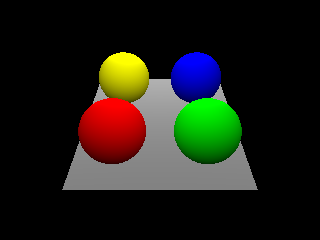

320

240

# Creating Renderer: Simple Raytracer
# RENDER STATISTICS###############################
TIME FOR RENDERING: 51.34657549858093s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 1495.718054305735
##################################################



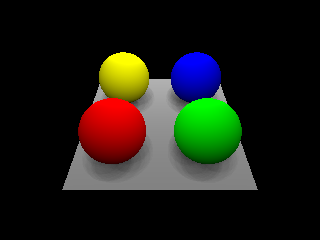

320

240

In [8]:
engin = SimpleRT()
display(engin.render(scene), w, h)

ao_engin = AOSimpleRT()
display(ao_engin.render(scene), w, h)